# Image classification

In [1]:
import torch
from torch import Generator

# Set the random seed for reproducibility
random_state = 42

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Preprocessing

In [3]:
import os
from data import train_val_split

base_dir = './data/train'
train_dir = './data/preprocessed/train'
val_dir = './data/preprocessed/val'

val_ratio = 0.2

if not os.path.exists(train_dir) and not os.path.exists(val_dir):
    train_val_split(base_dir, train_dir, val_dir, val_ratio, random_state) 

    print("Saved train data to:", train_dir)
    print("Saved validation data to:", val_dir)
else:
    print("Train and validation directories already exist.")

Train and validation directories already exist.


## Data

### Augmentation

In [4]:
import torchvision.transforms as transforms

mean_tensor = torch.tensor([0.5, 0.5, 0.5])
std_tensor = torch.tensor([0.5, 0.5, 0.5])

# mean_tensor = torch.tensor([0.5209, 0.4955, 0.4384])
# std_tensor = torch.tensor([0.2111, 0.2103, 0.2101])

default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

### Datasets and sampling

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from data import sample_dataset

train_default_ds = ImageFolder(train_dir, transform=default_transform)
train_augmented_ds = ImageFolder(train_dir, transform=augmented_transform)
train_ds = ConcatDataset([train_default_ds, train_augmented_ds])

val_ds = ImageFolder(val_dir, transform=default_transform)

# downsample the dataset
sample_ratio = 1
sampled_train_ds = sample_dataset(train_ds, sample_ratio, seed=random_state)
sampled_val_ds = sample_dataset(val_ds, sample_ratio, seed=random_state)

num_classes = len(train_default_ds.classes)

print(f"Number of training samples: {len(sampled_train_ds)}")
print(f"Number of validation samples: {len(sampled_val_ds)}")

Number of training samples: 140818
Number of validation samples: 17602


In [6]:
# from plots import plot_class_distribution

# plot_class_distribution(sampled_train_ds)

### Data loaders

In [7]:
batch_size = 256
num_workers = 0

# setup data loaders
train_dl = DataLoader(sampled_train_ds,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      generator=Generator().manual_seed(random_state))

val_dl = DataLoader(sampled_val_ds,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=False)

### Example

Sample image shape: torch.Size([3, 64, 64])
Sample label: 0


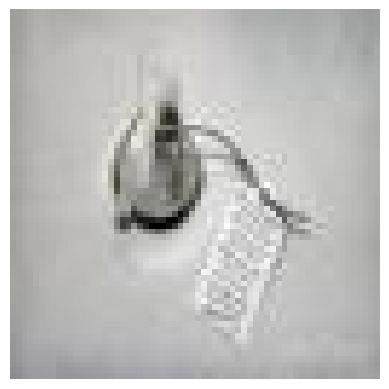

In [8]:
from utils import show_image

sample_img, sample_label = train_ds[0]

print(f"Sample image shape: {sample_img.size()}")
print(f"Sample label: {sample_label}")

show_image(sample_img)

## Training

In [9]:
from training import Trainer
import torch.optim as optim

### BasicModel

In [10]:
from models import BasicNet

basicNet = BasicNet(num_classes=num_classes)

optimizer = optim.AdamW(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=20)

Epoch 1/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 1/20: Train Loss: 3.8354, Val Loss: 3.6940, Avg Class Accuracy: 0.0769


Epoch 2/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch 2/20: Train Loss: 3.5811, Val Loss: 3.3599, Avg Class Accuracy: 0.1300


Epoch 3/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch 3/20: Train Loss: 3.4320, Val Loss: 3.2043, Avg Class Accuracy: 0.1515


Epoch 4/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Epoch 4/20: Train Loss: 3.3193, Val Loss: 3.1242, Avg Class Accuracy: 0.1950


Epoch 5/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch 5/20: Train Loss: 3.2187, Val Loss: 3.0076, Avg Class Accuracy: 0.2057


Epoch 6/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epoch 6/20: Train Loss: 3.1299, Val Loss: 2.8990, Avg Class Accuracy: 0.2498


Epoch 7/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Epoch 7/20: Train Loss: 3.0629, Val Loss: 2.8780, Avg Class Accuracy: 0.2563


Epoch 8/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch 8/20: Train Loss: 2.9860, Val Loss: 2.8073, Avg Class Accuracy: 0.2691


Epoch 9/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Epoch 9/20: Train Loss: 2.9233, Val Loss: 2.7752, Avg Class Accuracy: 0.2676


Epoch 10/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Epoch 10/20: Train Loss: 2.8682, Val Loss: 2.7093, Avg Class Accuracy: 0.2840


Epoch 11/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch 11/20: Train Loss: 2.8165, Val Loss: 2.6399, Avg Class Accuracy: 0.2865


Epoch 12/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Epoch 12/20: Train Loss: 2.7481, Val Loss: 2.5963, Avg Class Accuracy: 0.2978


Epoch 13/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Epoch 13/20: Train Loss: 2.6967, Val Loss: 2.5657, Avg Class Accuracy: 0.3158


Epoch 14/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Epoch 14/20: Train Loss: 2.6512, Val Loss: 2.5418, Avg Class Accuracy: 0.3106


Epoch 15/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch 15/20: Train Loss: 2.6086, Val Loss: 2.4970, Avg Class Accuracy: 0.3209


Epoch 16/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Epoch 16/20: Train Loss: 2.5816, Val Loss: 2.4758, Avg Class Accuracy: 0.3291


Epoch 17/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Epoch 17/20: Train Loss: 2.5344, Val Loss: 2.4542, Avg Class Accuracy: 0.3409


Epoch 18/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Epoch 18/20: Train Loss: 2.5081, Val Loss: 2.4027, Avg Class Accuracy: 0.3378


Epoch 19/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch 19/20: Train Loss: 2.4579, Val Loss: 2.3929, Avg Class Accuracy: 0.3376


Epoch 20/20 (validation): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

Epoch 20/20: Train Loss: 2.4334, Val Loss: 2.3557, Avg Class Accuracy: 0.3519


### Basic ResNet

In [ ]:
from models import BasicResNet

basicResNet = BasicResNet(num_classes=num_classes)

optimizer = optim.AdamW(basicResNet.to(device).parameters(), lr=1e-4, weight_decay=1e-4)

trainer = Trainer(basicResNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=50)

Epoch 1/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 1/50: Train Loss: 2.8239, Val Loss: 2.4377, Avg Class Accuracy: 0.3323


Epoch 2/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 2/50: Train Loss: 2.2333, Val Loss: 2.2033, Avg Class Accuracy: 0.4042


Epoch 3/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 3/50: Train Loss: 1.9612, Val Loss: 1.9874, Avg Class Accuracy: 0.4531


Epoch 4/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 4/50: Train Loss: 1.7686, Val Loss: 1.7886, Avg Class Accuracy: 0.5068


Epoch 5/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 5/50: Train Loss: 1.6128, Val Loss: 1.7283, Avg Class Accuracy: 0.5146


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 6/50: Train Loss: 1.4916, Val Loss: 1.5974, Avg Class Accuracy: 0.5515


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 7/50: Train Loss: 1.3862, Val Loss: 1.5549, Avg Class Accuracy: 0.5608


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 8/50: Train Loss: 1.2940, Val Loss: 1.5526, Avg Class Accuracy: 0.5663


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


Epoch 9/50: Train Loss: 1.2144, Val Loss: 1.5295, Avg Class Accuracy: 0.5766


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


Epoch 10/50: Train Loss: 1.1474, Val Loss: 1.4671, Avg Class Accuracy: 0.5932


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 11/50: Train Loss: 1.0796, Val Loss: 1.5496, Avg Class Accuracy: 0.5773


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 12/50: Train Loss: 1.0202, Val Loss: 1.4111, Avg Class Accuracy: 0.6100


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 13/50: Train Loss: 0.9655, Val Loss: 1.5639, Avg Class Accuracy: 0.5865


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.74it/s]


Epoch 14/50: Train Loss: 0.9126, Val Loss: 1.4164, Avg Class Accuracy: 0.6180


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 15/50: Train Loss: 0.8664, Val Loss: 1.4535, Avg Class Accuracy: 0.6087


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 16/50: Train Loss: 0.8228, Val Loss: 1.4319, Avg Class Accuracy: 0.6168


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 17/50: Train Loss: 0.7864, Val Loss: 1.5126, Avg Class Accuracy: 0.6043


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 18/50: Train Loss: 0.7429, Val Loss: 1.3737, Avg Class Accuracy: 0.6274


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.73it/s]


Epoch 19/50: Train Loss: 0.7041, Val Loss: 1.4430, Avg Class Accuracy: 0.6181


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 20/50: Train Loss: 0.6761, Val Loss: 1.4727, Avg Class Accuracy: 0.6206


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 21/50: Train Loss: 0.6541, Val Loss: 1.4759, Avg Class Accuracy: 0.6231


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 22/50: Train Loss: 0.6196, Val Loss: 1.5446, Avg Class Accuracy: 0.6250


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.78it/s]


Epoch 23/50: Train Loss: 0.5927, Val Loss: 1.4938, Avg Class Accuracy: 0.6322


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 24/50: Train Loss: 0.5705, Val Loss: 1.4914, Avg Class Accuracy: 0.6292


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.77it/s]


Epoch 25/50: Train Loss: 0.5483, Val Loss: 1.4775, Avg Class Accuracy: 0.6349


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 26/50: Train Loss: 0.5313, Val Loss: 1.5059, Avg Class Accuracy: 0.6340


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.66it/s]


Epoch 27/50: Train Loss: 0.5126, Val Loss: 1.4565, Avg Class Accuracy: 0.6397


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 28/50: Train Loss: 0.4967, Val Loss: 1.4610, Avg Class Accuracy: 0.6385


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 29/50: Train Loss: 0.4802, Val Loss: 1.4760, Avg Class Accuracy: 0.6409


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.76it/s]


Epoch 30/50: Train Loss: 0.4643, Val Loss: 1.4632, Avg Class Accuracy: 0.6415


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.72it/s]


Epoch 31/50: Train Loss: 0.4568, Val Loss: 1.4802, Avg Class Accuracy: 0.6439


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 32/50: Train Loss: 0.4381, Val Loss: 1.5263, Avg Class Accuracy: 0.6407


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 33/50: Train Loss: 0.4255, Val Loss: 1.4726, Avg Class Accuracy: 0.6472


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 34/50: Train Loss: 0.4128, Val Loss: 1.5213, Avg Class Accuracy: 0.6498


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 35/50: Train Loss: 0.3994, Val Loss: 1.5918, Avg Class Accuracy: 0.6447


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 36/50: Train Loss: 0.3923, Val Loss: 1.5485, Avg Class Accuracy: 0.6440


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 37/50: Train Loss: 0.3788, Val Loss: 1.5804, Avg Class Accuracy: 0.6405


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.71it/s]


Epoch 38/50: Train Loss: 0.3743, Val Loss: 1.5534, Avg Class Accuracy: 0.6469


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.75it/s]


Epoch 39/50: Train Loss: 0.3599, Val Loss: 1.5862, Avg Class Accuracy: 0.6481


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.62it/s]


Epoch 40/50: Train Loss: 0.3537, Val Loss: 1.5596, Avg Class Accuracy: 0.6423


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 41/50: Train Loss: 0.3458, Val Loss: 1.6147, Avg Class Accuracy: 0.6420


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.29it/s]


Epoch 42/50: Train Loss: 0.3357, Val Loss: 1.5304, Avg Class Accuracy: 0.6478


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.69it/s]


Epoch 43/50: Train Loss: 0.3327, Val Loss: 1.5647, Avg Class Accuracy: 0.6562


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 44/50: Train Loss: 0.3208, Val Loss: 1.5456, Avg Class Accuracy: 0.6512


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Epoch 45/50: Train Loss: 0.3155, Val Loss: 1.5821, Avg Class Accuracy: 0.6459


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.30it/s]


Epoch 46/50: Train Loss: 0.3118, Val Loss: 1.6188, Avg Class Accuracy: 0.6486


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 47/50: Train Loss: 0.3028, Val Loss: 1.5328, Avg Class Accuracy: 0.6611


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 48/50: Train Loss: 0.2979, Val Loss: 1.6162, Avg Class Accuracy: 0.6487


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:21<00:00,  3.14it/s]


Epoch 49/50: Train Loss: 0.2882, Val Loss: 1.5942, Avg Class Accuracy: 0.6505


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:22<00:00,  3.12it/s]

Epoch 50/50: Train Loss: 0.2801, Val Loss: 1.6138, Avg Class Accuracy: 0.6516


In [ ]:
torch.save(basicResNet.state_dict(), "./models/basicResNet.pth")

#### Base ResNet

In [13]:
from models import BasicResNet

lr = 1e-4
weight_decay = 1e-3
epochs = 50

pretrainedResNet = BasicResNet(num_classes=num_classes)

optimizer = optim.AdamW(pretrainedResNet.to(device).parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

trainer = Trainer(pretrainedResNet, train_dl, val_dl,optimizer, scheduler=scheduler, device=device)
trainer.train(num_epochs=epochs)

Epoch 1/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.30it/s]


Epoch 1/50: Train Loss: 2.8614, Val Loss: 2.4147, Avg Class Accuracy: 0.3351


Epoch 2/50 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.32it/s]


Epoch 2/50: Train Loss: 2.2776, Val Loss: 2.2111, Avg Class Accuracy: 0.3858


Epoch 3/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.27it/s]


Epoch 3/50: Train Loss: 2.0026, Val Loss: 1.9712, Avg Class Accuracy: 0.4556


Epoch 4/50 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.34it/s]


Epoch 4/50: Train Loss: 1.8114, Val Loss: 1.8380, Avg Class Accuracy: 0.4942


Epoch 5/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Epoch 5/50: Train Loss: 1.6583, Val Loss: 1.8106, Avg Class Accuracy: 0.5000


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 6/50: Train Loss: 1.5261, Val Loss: 1.7664, Avg Class Accuracy: 0.5131


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.18it/s]


Epoch 7/50: Train Loss: 1.4120, Val Loss: 1.7158, Avg Class Accuracy: 0.5298


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.24it/s]


Epoch 8/50: Train Loss: 1.3118, Val Loss: 1.6830, Avg Class Accuracy: 0.5415


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.22it/s]


Epoch 9/50: Train Loss: 1.2137, Val Loss: 1.6824, Avg Class Accuracy: 0.5423


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 10/50: Train Loss: 1.1326, Val Loss: 1.6905, Avg Class Accuracy: 0.5488


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.21it/s]


Epoch 11/50: Train Loss: 1.0581, Val Loss: 1.6572, Avg Class Accuracy: 0.5565


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 12/50: Train Loss: 0.9864, Val Loss: 1.7076, Avg Class Accuracy: 0.5503


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.20it/s]


Epoch 13/50: Train Loss: 0.9253, Val Loss: 1.6993, Avg Class Accuracy: 0.5613


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


Epoch 14/50: Train Loss: 0.8768, Val Loss: 1.6878, Avg Class Accuracy: 0.5652


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.17it/s]


Epoch 15/50: Train Loss: 0.8276, Val Loss: 1.6793, Avg Class Accuracy: 0.5727


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.29it/s]


Epoch 16/50: Train Loss: 0.7867, Val Loss: 1.7074, Avg Class Accuracy: 0.5686


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.22it/s]


Epoch 17/50: Train Loss: 0.7477, Val Loss: 1.7059, Avg Class Accuracy: 0.5696


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.21it/s]


Epoch 18/50: Train Loss: 0.7118, Val Loss: 1.7088, Avg Class Accuracy: 0.5758


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Epoch 19/50: Train Loss: 0.6857, Val Loss: 1.7116, Avg Class Accuracy: 0.5796


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.20it/s]


Epoch 20/50: Train Loss: 0.6558, Val Loss: 1.7238, Avg Class Accuracy: 0.5749


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Epoch 21/50: Train Loss: 0.6365, Val Loss: 1.6990, Avg Class Accuracy: 0.5869


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.24it/s]


Epoch 22/50: Train Loss: 0.6201, Val Loss: 1.7060, Avg Class Accuracy: 0.5846


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


Epoch 23/50: Train Loss: 0.5972, Val Loss: 1.7625, Avg Class Accuracy: 0.5794


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.14it/s]


Epoch 24/50: Train Loss: 0.5741, Val Loss: 1.7228, Avg Class Accuracy: 0.5840


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.16it/s]


Epoch 25/50: Train Loss: 0.5571, Val Loss: 1.7103, Avg Class Accuracy: 0.5920


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.22it/s]


Epoch 26/50: Train Loss: 0.5388, Val Loss: 1.7354, Avg Class Accuracy: 0.5895


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.16it/s]


Epoch 27/50: Train Loss: 0.5241, Val Loss: 1.7023, Avg Class Accuracy: 0.5942


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.27it/s]


Epoch 28/50: Train Loss: 0.5093, Val Loss: 1.7312, Avg Class Accuracy: 0.5931


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.28it/s]


Epoch 29/50: Train Loss: 0.4960, Val Loss: 1.7085, Avg Class Accuracy: 0.5945


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.21it/s]


Epoch 30/50: Train Loss: 0.4819, Val Loss: 1.7185, Avg Class Accuracy: 0.5981


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.11it/s]


Epoch 31/50: Train Loss: 0.4714, Val Loss: 1.7257, Avg Class Accuracy: 0.5955


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.13it/s]


Epoch 32/50: Train Loss: 0.4596, Val Loss: 1.6956, Avg Class Accuracy: 0.6016


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:17<00:00,  4.06it/s]


Epoch 33/50: Train Loss: 0.4461, Val Loss: 1.7118, Avg Class Accuracy: 0.6000


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.26it/s]


Epoch 34/50: Train Loss: 0.4349, Val Loss: 1.6904, Avg Class Accuracy: 0.6041


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.19it/s]


Epoch 35/50: Train Loss: 0.4215, Val Loss: 1.6753, Avg Class Accuracy: 0.6072


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.13it/s]


Epoch 36/50: Train Loss: 0.4141, Val Loss: 1.6837, Avg Class Accuracy: 0.6054


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.11it/s]


Epoch 37/50: Train Loss: 0.4053, Val Loss: 1.6840, Avg Class Accuracy: 0.6060


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.19it/s]


Epoch 38/50: Train Loss: 0.3987, Val Loss: 1.6767, Avg Class Accuracy: 0.6070


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.19it/s]


Epoch 39/50: Train Loss: 0.3903, Val Loss: 1.6758, Avg Class Accuracy: 0.6067


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 40/50: Train Loss: 0.3837, Val Loss: 1.6812, Avg Class Accuracy: 0.6064


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.19it/s]


Epoch 41/50: Train Loss: 0.3784, Val Loss: 1.6708, Avg Class Accuracy: 0.6092


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 42/50: Train Loss: 0.3712, Val Loss: 1.6599, Avg Class Accuracy: 0.6098


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.27it/s]


Epoch 43/50: Train Loss: 0.3680, Val Loss: 1.6636, Avg Class Accuracy: 0.6092


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


Epoch 44/50: Train Loss: 0.3645, Val Loss: 1.6611, Avg Class Accuracy: 0.6102


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.25it/s]


Epoch 45/50: Train Loss: 0.3611, Val Loss: 1.6651, Avg Class Accuracy: 0.6113


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.15it/s]


Epoch 46/50: Train Loss: 0.3548, Val Loss: 1.6633, Avg Class Accuracy: 0.6097


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.23it/s]


Epoch 47/50: Train Loss: 0.3569, Val Loss: 1.6635, Avg Class Accuracy: 0.6103


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.29it/s]


Epoch 48/50: Train Loss: 0.3534, Val Loss: 1.6617, Avg Class Accuracy: 0.6111


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.21it/s]


Epoch 49/50: Train Loss: 0.3525, Val Loss: 1.6594, Avg Class Accuracy: 0.6103


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:16<00:00,  4.24it/s]

Epoch 50/50: Train Loss: 0.3501, Val Loss: 1.6611, Avg Class Accuracy: 0.6104


#### Finetuning

In [10]:
from models import BasicResNet

lr = 1e-5
weight_decay = 1e-3
epochs = 10

fineTunedResNet = BasicResNet(num_classes=num_classes)
fineTunedResNet.load_state_dict(torch.load("./models/basicResNet.pth"))

optimizer = optim.AdamW(fineTunedResNet.to(device).parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

trainer = Trainer(fineTunedResNet, train_dl, val_dl, optimizer, scheduler=scheduler, device=device)
trainer.train(num_epochs=epochs)

Epoch 1/10 (validation): 100%|██████████| 69/69 [00:15<00:00,  4.35it/s]


Epoch 1/10: Train Loss: 2.1945, Val Loss: 2.4021, Avg Class Accuracy: 0.5381


Epoch 2/10 (training):   2%|▏         | 13/551 [00:03<02:19,  3.84it/s]


KeyboardInterrupt: 

### Four-block CNN

In [14]:
from models import FourBlockCNN

epochs = 50
lr = 1e-4
weight_decay = 1e-3

fourBlockCNN = FourBlockCNN(num_classes=num_classes)

optimizer = optim.Adam(fourBlockCNN.to(device).parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

trainer = Trainer(fourBlockCNN, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=epochs)

Epoch 1/50 (validation): 100%|██████████| 69/69 [00:17<00:00,  3.94it/s]


Epoch 1/50: Train Loss: 3.3547, Val Loss: 3.4746, Avg Class Accuracy: 0.1251


Epoch 2/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.82it/s]


Epoch 2/50: Train Loss: 2.8859, Val Loss: 3.2544, Avg Class Accuracy: 0.1744


Epoch 3/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.80it/s]


Epoch 3/50: Train Loss: 2.5974, Val Loss: 2.8474, Avg Class Accuracy: 0.2500


Epoch 4/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.80it/s]


Epoch 4/50: Train Loss: 2.3765, Val Loss: 2.7263, Avg Class Accuracy: 0.2770


Epoch 5/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.79it/s]


Epoch 5/50: Train Loss: 2.2149, Val Loss: 2.7148, Avg Class Accuracy: 0.2829


Epoch 6/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.65it/s]


Epoch 6/50: Train Loss: 2.0740, Val Loss: 2.3367, Avg Class Accuracy: 0.3616


Epoch 7/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.59it/s]


Epoch 7/50: Train Loss: 1.9690, Val Loss: 2.1734, Avg Class Accuracy: 0.4010


Epoch 8/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.67it/s]


Epoch 8/50: Train Loss: 1.8728, Val Loss: 2.2262, Avg Class Accuracy: 0.3993


Epoch 9/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.68it/s]


Epoch 9/50: Train Loss: 1.7945, Val Loss: 2.0234, Avg Class Accuracy: 0.4414


Epoch 10/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.61it/s]


Epoch 10/50: Train Loss: 1.7209, Val Loss: 1.8866, Avg Class Accuracy: 0.4860


Epoch 11/50 (validation): 100%|██████████| 69/69 [00:18<00:00,  3.64it/s]


Epoch 11/50: Train Loss: 1.6552, Val Loss: 2.0018, Avg Class Accuracy: 0.4536


Epoch 12/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.63it/s]


Epoch 12/50: Train Loss: 1.5989, Val Loss: 1.8563, Avg Class Accuracy: 0.4852


Epoch 13/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.63it/s]


Epoch 13/50: Train Loss: 1.5465, Val Loss: 1.8307, Avg Class Accuracy: 0.4929


Epoch 14/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.61it/s]


Epoch 14/50: Train Loss: 1.4941, Val Loss: 1.7430, Avg Class Accuracy: 0.5210


Epoch 15/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 15/50: Train Loss: 1.4501, Val Loss: 1.5602, Avg Class Accuracy: 0.5670


Epoch 16/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.61it/s]


Epoch 16/50: Train Loss: 1.4121, Val Loss: 1.6713, Avg Class Accuracy: 0.5381


Epoch 17/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 17/50: Train Loss: 1.3731, Val Loss: 1.5135, Avg Class Accuracy: 0.5821


Epoch 18/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.60it/s]


Epoch 18/50: Train Loss: 1.3390, Val Loss: 1.5478, Avg Class Accuracy: 0.5701


Epoch 19/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 19/50: Train Loss: 1.3069, Val Loss: 1.4722, Avg Class Accuracy: 0.5908


Epoch 20/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Epoch 20/50: Train Loss: 1.2735, Val Loss: 1.5357, Avg Class Accuracy: 0.5750


Epoch 21/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 21/50: Train Loss: 1.2468, Val Loss: 1.4524, Avg Class Accuracy: 0.5943


Epoch 22/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.57it/s]


Epoch 22/50: Train Loss: 1.2157, Val Loss: 1.3776, Avg Class Accuracy: 0.6137


Epoch 23/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch 23/50: Train Loss: 1.1880, Val Loss: 1.4575, Avg Class Accuracy: 0.6004


Epoch 24/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 24/50: Train Loss: 1.1603, Val Loss: 1.4478, Avg Class Accuracy: 0.6009


Epoch 25/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 25/50: Train Loss: 1.1399, Val Loss: 1.4318, Avg Class Accuracy: 0.6064


Epoch 26/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 26/50: Train Loss: 1.1173, Val Loss: 1.3780, Avg Class Accuracy: 0.6181


Epoch 27/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 27/50: Train Loss: 1.0967, Val Loss: 1.3692, Avg Class Accuracy: 0.6184


Epoch 28/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch 28/50: Train Loss: 1.0734, Val Loss: 1.3605, Avg Class Accuracy: 0.6250


Epoch 29/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 29/50: Train Loss: 1.0537, Val Loss: 1.3339, Avg Class Accuracy: 0.6304


Epoch 30/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 30/50: Train Loss: 1.0357, Val Loss: 1.3468, Avg Class Accuracy: 0.6269


Epoch 31/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 31/50: Train Loss: 1.0149, Val Loss: 1.2751, Avg Class Accuracy: 0.6459


Epoch 32/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch 32/50: Train Loss: 1.0005, Val Loss: 1.3039, Avg Class Accuracy: 0.6393


Epoch 33/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch 33/50: Train Loss: 0.9747, Val Loss: 1.3577, Avg Class Accuracy: 0.6271


Epoch 34/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch 34/50: Train Loss: 0.9645, Val Loss: 1.2894, Avg Class Accuracy: 0.6447


Epoch 35/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 35/50: Train Loss: 0.9473, Val Loss: 1.3243, Avg Class Accuracy: 0.6338


Epoch 36/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 36/50: Train Loss: 0.9329, Val Loss: 1.4098, Avg Class Accuracy: 0.6147


Epoch 37/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 37/50: Train Loss: 0.9162, Val Loss: 1.2929, Avg Class Accuracy: 0.6459


Epoch 38/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch 38/50: Train Loss: 0.9005, Val Loss: 1.2198, Avg Class Accuracy: 0.6643


Epoch 39/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.50it/s]


Epoch 39/50: Train Loss: 0.8859, Val Loss: 1.2849, Avg Class Accuracy: 0.6486


Epoch 40/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch 40/50: Train Loss: 0.8738, Val Loss: 1.3259, Avg Class Accuracy: 0.6417


Epoch 41/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch 41/50: Train Loss: 0.8603, Val Loss: 1.2907, Avg Class Accuracy: 0.6474


Epoch 42/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.56it/s]


Epoch 42/50: Train Loss: 0.8452, Val Loss: 1.2787, Avg Class Accuracy: 0.6556


Epoch 43/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch 43/50: Train Loss: 0.8377, Val Loss: 1.3209, Avg Class Accuracy: 0.6464


Epoch 44/50 (validation): 100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch 44/50: Train Loss: 0.8263, Val Loss: 1.2282, Avg Class Accuracy: 0.6636


Epoch 45/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.55it/s]


Epoch 45/50: Train Loss: 0.8114, Val Loss: 1.2937, Avg Class Accuracy: 0.6479


Epoch 46/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch 46/50: Train Loss: 0.8022, Val Loss: 1.2591, Avg Class Accuracy: 0.6638


Epoch 47/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.53it/s]


Epoch 47/50: Train Loss: 0.7948, Val Loss: 1.2627, Avg Class Accuracy: 0.6606


Epoch 48/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.51it/s]


Epoch 48/50: Train Loss: 0.7814, Val Loss: 1.2561, Avg Class Accuracy: 0.6589


Epoch 49/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.52it/s]


Epoch 49/50: Train Loss: 0.7729, Val Loss: 1.2780, Avg Class Accuracy: 0.6576


Epoch 50/50 (validation): 100%|██████████| 69/69 [00:19<00:00,  3.46it/s]

Epoch 50/50: Train Loss: 0.7614, Val Loss: 1.2005, Avg Class Accuracy: 0.6779


## Save results

In [15]:
from evaluation import save_results

test_dir = './data/test_all'

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tensor, std_tensor)
])

save_results(fourBlockCNN, test_dir, test_transform, device=device)

Processing images: 100%|██████████| 10000/10000 [00:36<00:00, 277.09it/s]

Saved 10000 predictions to pred.csv
